In [1]:
# https://tinygp.readthedocs.io/en/stable/tutorials/intro.html

In [2]:
import jax

# enable double precision to avoid some numerical precision issues
jax.config.update("jax_enable_x64", True)

In [3]:
import tinygp

In [4]:
tinygp.__version__

'0.2.3'

In [5]:
from tinygp import kernels

In [6]:
kernel = kernels.ExpSquared(scale=1.5)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")

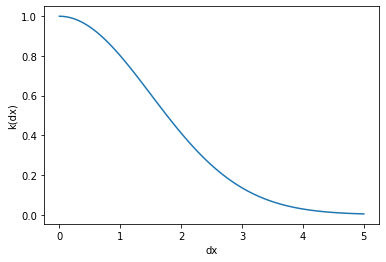

In [9]:
plot_kernel(kernel)

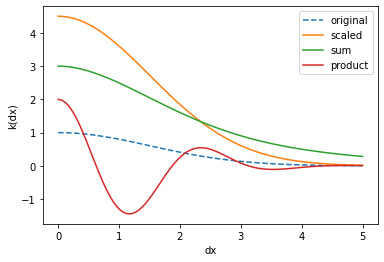

In [10]:
plot_kernel(kernel, label="original", ls="dashed")

kernel_scaled = 4.5 * kernels.ExpSquared(scale=1.5)
plot_kernel(kernel_scaled, label="scaled")

kernel_sum = kernels.ExpSquared(scale=1.5) + 2 * kernels.Matern32(scale=2.5)
plot_kernel(kernel_sum, label="sum")

kernel_prod = 2 * kernels.ExpSquared(scale=1.5) * kernels.Cosine(scale=2.5)
plot_kernel(kernel_prod, label="product")

_ = plt.legend()

In [11]:
from tinygp import GaussianProcess

X = np.sort(np.random.default_rng(1).uniform(0, 10, 100))

gp = GaussianProcess(kernel, X)

In [12]:
?gp

Type:        GaussianProcess
String form: <tinygp.gp.GaussianProcess object at 0x1593069d0>
File:        /opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/tinygp/gp.py
Docstring:  
An interface for designing a Gaussian Process regression model

Args:
    kernel (Kernel): The kernel function
    X (JAXArray): The input coordinates. This can be any PyTree that is
        compatible with ``kernel`` where the zeroth dimension is ``N_data``,
        the size of the data set.
    diag (JAXArray, optional): The value to add to the diagonal of the
        covariance matrix, often used to capture measurement uncertainty.
        This should be a scalar or have the shape ``(N_data,)``. If not
        provided, this will default to the square root of machine epsilon
        for the data type being used. This can sometimes be sufficient to
        avoid numerical issues, but if you're getting NaNs, try increasing
        this value.
    noise (Noise, optional): Used to impl

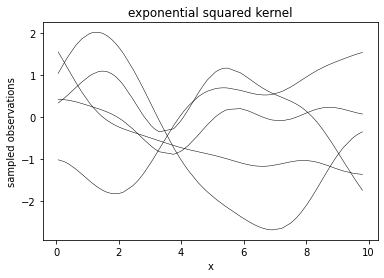

In [13]:
y = gp.sample(jax.random.PRNGKey(1), shape=(5,))
plt.plot(X, y.T, color='k', lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("exponential squared kernel")

In [14]:
X.shape

(100,)

In [15]:
diag = 1e-5
# diag = np.arange(len(X)) * 1e-1

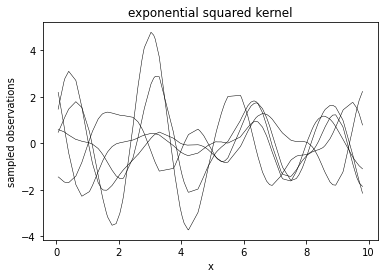

In [16]:

kernel_prod = 2 * kernels.ExpSquared(scale=1.5) * kernels.Cosine(scale=2.5)
gp = GaussianProcess(kernel_prod, X, diag=diag)

y = gp.sample(jax.random.PRNGKey(1), shape=(5,))
plt.plot(X, y.T, color='k', lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("exponential squared kernel")

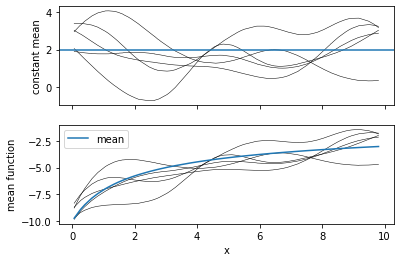

In [17]:
# A GP with a non-zero constant mean
gp = GaussianProcess(kernel, X, diag=1e-5, mean=2.0)
y_const = gp.sample(jax.random.PRNGKey(4), shape=(5,))

# # And a GP with a general mean function
def mean_function(x):
    # return 5 * jax.numpy.sin(x)
    # return 5 * jax.numpy.log(jax.numpy.abs(x))
    return -10/(1+x)**0.5


gp = GaussianProcess(kernel, X, diag=1e-5, mean=mean_function)
y_func = gp.sample(jax.random.PRNGKey(4), shape=(5,))

# Plotting these samples
_, axes = plt.subplots(2, 1, sharex=True)
ax = axes[0]
ax.plot(X, y_const.T, color="k", lw=0.5)
ax.axhline(2.0)
ax.set_ylabel("constant mean")

ax = axes[1]
ax.plot(X, y_func.T, color="k", lw=0.5)
ax.plot(X, jax.vmap(mean_function)(X), label="mean")
ax.legend()
ax.set_xlabel("x")
_ = ax.set_ylabel("mean function")

In [18]:
# conditioning and marinalization

In [24]:
# Simulate a made up dataset, as an example
random = np.random.default_rng(1)
X = np.sort(random.uniform(0, 10, 10))
y = np.sin(X) + 1e-4 * random.normal(size=X.shape)

# Compute the log probability
kernel = 0.5 * kernels.ExpSquared(scale=1.0)
gp = GaussianProcess(kernel, X, diag=1e-4)
print(gp.log_probability(y))


0.16462032491340528


In [25]:
cond = gp.condition(y)
print(cond.log_probability)

0.16462032491340528


In [26]:
X_test = np.linspace(0, 10, 100)

In [27]:
_, cond_gp = gp.condition(y, X_test)

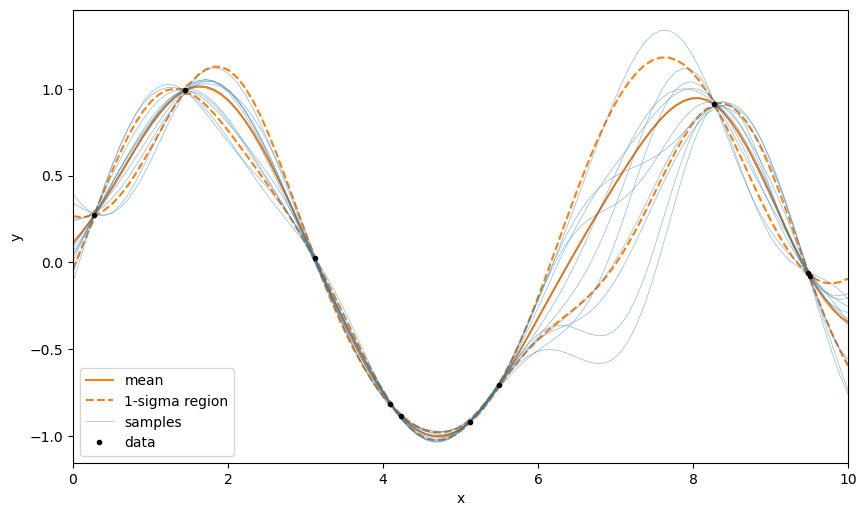

In [28]:
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(X_test, mu, "C1", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5);

plt.plot(X, y, ".k", label="data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel("x")
_ = plt.ylabel("y")